# Dynamic model

ReviewNB link: https://app.reviewnb.com/orianebro/PhD_Oriane/blob/main/dynamic_model.ipynb

In [1]:
#| echo: false

# Ignore warning about depreciated modules
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Conceptual diagram

In [2]:
#| echo: false
# ![Conceptual diagram of shoot FSPM (not final version, some errors)](images/shoot_FSPM_conceptual_diagram_alone.jpg "Conceptual diagram")

The main stem grows according to the crop model's plant height.  
The appearance of a leaf is triggered by fixed phyllochron (different for tillers?).  
The angle of the leaf with its axis is leaf-age dependent. The leaf blade curvature depends on the angle with the axis and the leaf length.  
The reproductive organs appear from a given thermal time, when the leaves have stopped growing. 
Leaf senescence is constrained by crop model, as it has a direct influence on LAI (green LAI vs. yellow LAI ?).  
The branching pattern is set (Tillers (Zhu et al., 2015)). 

## Time-dependent parametrization of leaf area

$$ \mathcal{A_normalized} = 2 * |\int_{0}^{1} \mathcal{C}(s(u))ds(u)| $$
$$ \mathcal{A} = \mathcal{A_scaled} = 2 * w * |\int_{0}^{L} \mathcal{C}(\frac{s(u)}{L})d\frac{s(u)}{L}| $$
$$ \frac{d\mathcal{A}}{dt} = 2 * w * |\int_{ds(t)/L} \mathcal{C}(\frac{s(u)}{L})d\frac{s(u)}{L}| $$

- $\mathcal{A}$ : final leaf area (or surface), in $cm^2$ (given by crop model)
- $\frac{d\mathcal{A}}{dt}$ : gain in area, in $cm^2$, for a given leaf for a given time step $dt$ (given by crop model)  
- $\mathcal{C}$ : curve of the evolution of the leaf width along the leaf, **from tip to base** (literature/expert knowledge/observation)
- $s(t)$ : curvilinear abscissa of the midrib, in $cm$, as a function of thermal time $t$, such that: $ ds(t) = \sqrt{(dx(t))^2+(dy(t))^2} $ (computed from leaf curvature)
- $w$ : final maximal width of the leaf, in $cm$ (to fix/vary within a reasonable range)
- $L$ : final length of the leaf, in $cm$ (to fix/vary within a reasonable range)
- $t$ : thermal time, in $^oC.day$


The objective is to find, for each growing leaf, at each time step, and for a given leaf area provided to the leaf $\frac{d\mathcal{A}}{dt}$, how much length $ds(t)$ is added to the leaf.

$$ \frac{d\mathcal{A}}{dt} = 2w |\int_{s(t-1)/L}^{s(t)/L} \mathcal{C}(\frac{s(u)}{L})d\frac{s(u)}{L}| $$

According to the Fundamental Theorem of Calculus, $\mathcal{C}$ being at least $C^0$ on $[0,L]$, $F$ being the antiderivative of $\mathcal{C}$, we can write:

$$ \frac{d\mathcal{A}}{dt} = 2w (|F(\frac{s(t)}{L}) - F(\frac{s(t-1)}{L})|) $$

$$ F(\frac{s(t)}{L}) = |\frac{1}{2w} \frac{d\mathcal{A}}{dt} + F(\frac{s(t-1)}{L})| $$

Knowing the other variables, we know have to determine $s(t)$ at thermal time $t$.

## Apparition and growth of phytomers (stem and leaf)

The height of the plant/canopy (here we consider the height of the main stem) is given by the crop model.  
The plastochron (i.e. leaf initiation rate, in $leaf^{-1}$) is the time interval between two successive leaves produced at the SAM.  
The phyllochron (i.e. leaf emergence rate, in $leaf^{-1}$) is the time interval between two successive leaves emerging from the top of the former leaf sheath.  
The time for a leaf to grow is roughly between 1.5 and 2 phyllochrons.  
We consider a linear (rough approximation of beta function) growth for the leaf.  

- $\phi$ : phyllochron, in $^oC.day.leaf^{-1}$ (literature)
- cur_len_int : current length of growing internodes
- fin_len_int : final length of internodes, in $cm$ (literature, bell shaped model too ?)
- height : plant height, in $cm$ (given by crop model)
- $[s(t)]$ : current length of growing leaves, in $cm$ (computed before)
- fin_len_leaf : final length of leaves, in $cm$  (bell shaped model)
- leaf expansion duration, as $x * \phi$, in $^oC.day$ (literature, cf Clerget et al., 2008, etc)  

Cf Fournier et al, 2005; Stewart and Dwyer, 1993; Skinner and Nelson, 1995  



## Visualize a growing plant

In [3]:
## Imports

# from installed packages
import numpy as np
import matplotlib.pyplot as plt
from openalea.plantgl.all import Vector3
from oawidgets.plantgl import *

# from archicrop
from openalea.archicrop.cereals_leaf import parametric_leaf
from openalea.archicrop.plant_shape import geometric_dist, bell_shaped_dist, compute_leaf_area
from openalea.archicrop.plant_design import leaf_azimuth
from openalea.archicrop.cereals import build_shoot
from openalea.archicrop.display import display_mtg, build_scene, display_scene

# Enable plotting with PlantGL
%gui qt

# Set nice color for plants
nice_green=Color3((50,100,0))

## Code for generating a 3D cereal shoot from descritive parameters

# Parameters 
height=1000                 # from crop model
nb_phy=17 
max_leaf_length=85 


shoot, g = build_shoot(nb_phy=nb_phy,
                        height=height,
                        max_leaf_length=max_leaf_length)

# Build and display scene
scene, nump = build_scene(g, 
                          leaf_material=Material(nice_green), 
                          stem_material=Material(nice_green))
# display_scene(scene_single) # display in separate window
# PlantGL(scene) # display in notebook

In [4]:
from ipywidgets import interact, interactive, IntSlider, fixed
from openalea.archicrop.dynamic import grow_plant, grow_plant_and_display

def grow_plant_and_display_in_NB(g, time):
    g, scene, nump=grow_plant_and_display(g, time, phyllochron=110)
    w=PlantGL(scene, group_by_color=True)
    w.wireframe=True
    return w

# max_time = max(g.property('end_tt').values())
interact(grow_plant_and_display_in_NB, g=fixed(g), time=IntSlider(min=20, max=2000, step=100, value=1000))

interactive(children=(IntSlider(value=1000, description='time', max=2000, min=20, step=100), Output()), _dom_c…

<function __main__.grow_plant_and_display_in_NB(g, time)>

In [5]:
from oawidgets.mtg import plot as MTGw
# MTGw(g, properties='label')
# g.display()

## Fit plant growth and development to LAI(t) and height(t) curves from crop model

Two constraints :

$$ \mathcal{A} = \mathcal{A_scaled} = 2 w |\int_{L}^{0} \mathcal{C}(\frac{s(u)}{L})d\frac{s(u)}{L}| $$
where $$\mathcal{C}(x) = \alpha x^2 - 2 (\alpha + \sqrt{-\alpha}) x + 2 \sqrt{-\alpha} + \alpha$$

and
$$ \text{leaf length} = L  e^{-\log(skew) * (2 (z - zmax)^2 + (z - zmax)^3)} $$


In [6]:
shoot, g = build_shoot(nb_phy=nb_phy,
                        height=height,
                        max_leaf_length=max_leaf_length)

# For loop for generating plants at different stages
for time in [0,84,136,249,385,465,598,672,723,862,942,1025,1148,1295,1363,1472,1538,1618,1702,1899,1988]:
    LAs = compute_leaf_area(grow_plant(g, time=time, phyllochron=110))


# plt.clf()
# plt.plot(range(0,nb_phy), LAs)
# plt.show()

In [7]:
from scipy.optimize import curve_fit, least_squares

# Sources
# Toungos, 2019, 10.5281/Zendo.2653098. 
# dos Santos et al., 2022, 10.3389/fpls.2022.872738

def parametric_model_maize(thermal_time, max_leaf_length, phyllochron):
    """
    Define parametric model.

    Args:
    - thermal_time: Input values
    - max_leaf_length, phyllochron: Parameters of the model

    Returns:
    - leaf_areas: Output values corresponding to the model
    """
    
    height=300                 
    nb_phy=20 
    
    shoot, g = build_shoot(nb_phy=nb_phy,
                            height=height,
                            max_leaf_length=max_leaf_length,
                            wl=0.15, diam_base=2.5, diam_top=1.0, 
                            insertion_angle=30, scurv=0.7, curvature=90, 
                            alpha=-2.3, stem_q=1.2, rmax=0.8, skew=0.2,
                            phyllotactic_angle=180, phyllotactic_deviation=0, plant_orientation=0, spiral=True)


    leaf_areas = []
    for t in thermal_time:
        leaf_areas.append(sum(compute_leaf_area(grow_plant(g, time=t, phyllochron=phyllochron))))

    return leaf_areas


### From STICS simulation for maize

In [8]:
## From a STICS simulation for maize

def read_columns_from_file(filename, separator=';'):
    with open(filename, 'r') as file:
        columns = []
        for line in file:
            values = line.strip().split(separator) # Strip any extra whitespace and split the line by the separator
            if not columns:
                columns = [[] for _ in values]
            while len(columns) < len(values):
                columns.append([])
            for i, value in enumerate(values):
                columns[i].append(value)
            # Handle lines with fewer values than columns
            for i in range(len(values), len(columns)):
                columns[i].append('')
    return columns


filename = 'mod_smaize.sti'
columns = read_columns_from_file(filename)
columns = columns[5:]

end = 115
cm_la = [float(i)/0.00095 for i in columns[0][18:end]] # density = 9.5 plant/m2 = 0.00095 plant/cm2
cm_height = [float(i) for i in columns[1][18:end]]
cm_tt = np.cumsum([float(i) for i in columns[2][18:end]])

x_data = []
y_data = []
for i,t in enumerate(cm_tt):
    x_data.append(t)
    y_data.append(cm_la[i])
x_data = np.array(x_data)  # input data
y_data = np.array(y_data)  # output data

                  Max leaf length  Phyllochron
Optimized parameters: [56.70458281 35.4181157 ]
Standard errors: [0.29165666 0.19766131]


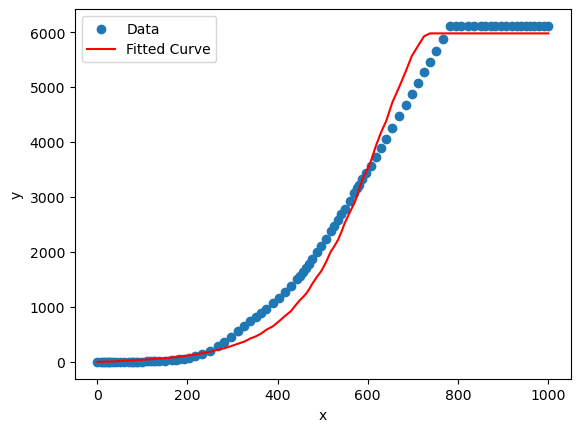

In [9]:
# Fit the model to crop model data and obtain optimal parameters
optimal_params, covariance = curve_fit(f=parametric_model_maize, xdata=x_data, ydata=y_data, bounds=([50,20],[100,90]), method='trf') # bounds to set from lit
se = np.sqrt(np.diag(covariance))

print("                  Max leaf length  Phyllochron")
print("Optimized parameters:", optimal_params)
# print("Covariances:", covariance)
print("Standard errors:", se)

# Visualize the fit
plt.clf()
plt.scatter(x_data, y_data, label='Data')
plt.plot(x_data, parametric_model_maize(x_data, *optimal_params), color='red', label='Fitted Curve')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [10]:
# Define the model function
def parametric_model_maize_ls(params, thermal_time, y_data):
    """
    Define parametric model.

    Args:
    - thermal_time: Input values
    - max_leaf_length, phyllochron: Parameters of the model

    Returns:
    - leaf_areas: Output values corresponding to the model
    """

    max_leaf_length=params[0]
    phyllochron=params[1]
    
    height=300                 
    nb_phy=20 
    
    shoot, g = build_shoot(nb_phy=nb_phy,
                            height=height,
                            max_leaf_length=max_leaf_length,
                            wl=0.15, diam_base=2.5, diam_top=1.0, 
                            insertion_angle=30, scurv=0.7, curvature=90, 
                            alpha=-2.3, stem_q=1.2, rmax=0.8, skew=0.2,
                            phyllotactic_angle=180, phyllotactic_deviation=0, plant_orientation=0, spiral=True)


    leaf_areas = []
    for t in thermal_time:
        leaf_areas.append(sum(compute_leaf_area(grow_plant(g, time=t, phyllochron=phyllochron))))

    return y_data - leaf_areas


                   Max leaf length  Phyllochron
Optimized parameters: 56.70457981293104 35.41811165900665


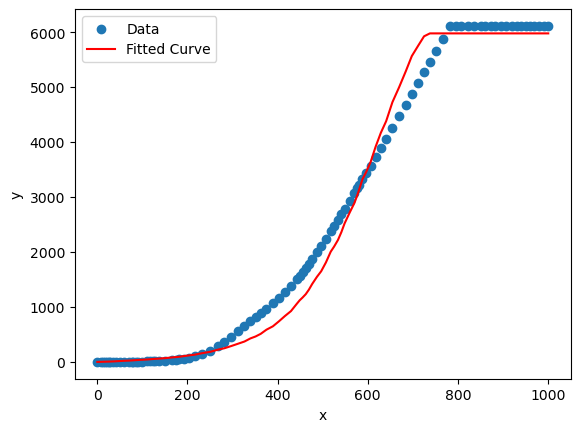

In [11]:
# Initial guess for the parameters
x0 = [80, 45]

# Perform the least squares optimization
result = least_squares(parametric_model_maize_ls, x0, args=(x_data, y_data), method='dogbox')

# Extract the optimized parameters
max_leaf_length_opt, phyllochron_opt = result.x
print("                   Max leaf length  Phyllochron")
print("Optimized parameters:", max_leaf_length_opt, phyllochron_opt)

# Visualize the fit
plt.clf()
plt.scatter(x_data, y_data, label='Data')
plt.plot(x_data, parametric_model_maize(x_data, *result.x), color='red', label='Fitted Curve')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [12]:
## Imports

# from installed packages
from random import *

# from archicrop
from openalea.archicrop.stand import agronomic_plot

# Enable plotting with PlantGL
%gui qt

## Code for generating ...
# Fix a seed
seed(100)

# Initialize the list of plants
plants_in_crop=[]

# Fixed parameters for all plants
length_plot=5
width_plot=5
sowing_density=9.5
plant_density=9.5
inter_row=0.5
nplants, positions, domain, domain_area, unit = agronomic_plot(length_plot, 
                                                               width_plot, 
                                                               sowing_density, 
                                                               plant_density, 
                                                               inter_row, 
                                                               noise=0.1)

# For loop over all the plants in the crop
for n in range(nplants):

    # Parameters 
    max_leaf_length=optimal_params[0]
    phyllochron=optimal_params[1]
    height=300                 
    nb_phy=20 
    
    
    shoot, g = build_shoot(nb_phy=nb_phy,
                            height=height,
                            max_leaf_length=max_leaf_length,
                            wl=0.15, diam_base=2.5, diam_top=1.0, 
                            insertion_angle=30, scurv=0.7, curvature=90, 
                            alpha=-2.3, stem_q=1.2, rmax=0.8, skew=0.2,
                            phyllotactic_angle=180,
                            plant_orientation=random()*360,
                            phyllotactic_deviation=20)
    
    # Fill the list of plants
    plants_in_crop.append(g) # put all plants in the same mtg to be able to visualize the dynamic growth easily

# Build and display scene
scene_var, nump = build_scene(plants_in_crop, positions, leaf_material=Material(nice_green), stem_material=Material(nice_green))
PlantGL(scene_var)
# interact(grow_plant_and_display_in_NB, g=fixed(plants_in_crop), time=IntSlider(min=20, max=2000, step=20, value=1000))

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], background…

## Leaf senescence

Yellow leaves corresponding to yellow LAI in STICS  

Age-dependent senescence, from tip to base, following the same dynamics as growth dynamics

## Next steps

- Fit for height (problem of non matching supposed vs actual height)
- Bending dynamics of leaves and tillers